In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import vice
import sys
sys.path.append("../")
from vice_utils import calculate_z, sample_stars, filter_stars, show_stars, R_to_zone, zone_to_R, show_at_R_z
from imp import reload
import vice_utils
from yields import y_c_agb
import warnings
import yields
from plotting import fig_saver
import scipy
import apogee_analysis as aah
import pandas as pd

/home/daniel/surp/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
sf = fig_saver("./figures")

In [4]:
tau_rise = 2
tau_sfh = 15
def sfh(t):
    return (1-np.exp(-t/tau_rise)) * np.exp(-t/tau_sfh)

A = 1.5
s_burst = 1
t_burst = 11.2
def lateburst(t):
    return sfh(t) * (1 + A * np.exp(-(t-t_burst)**2/(2*s_burst**2)))

In [5]:
def normalize(f):
    norm = scipy.integrate.quad(f, 0, 13.2)[0]
    return lambda x: f(x)/norm * 7

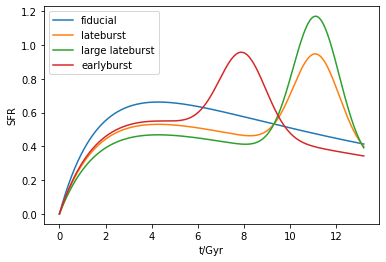

In [6]:
t = np.linspace(0, 13.2, 1000)
plt.plot(t, normalize(sfh)(t), label="fiducial")
plt.xlabel("t/Gyr")
plt.ylabel("SFR")
t_burst = 11.2
plt.plot(t, normalize(lateburst)(t), label="lateburst")
plt.xlabel("t/Gyr")
plt.ylabel("SFR")

A = 2.5
plt.plot(t, normalize(lateburst)(t), label="large lateburst")
plt.xlabel("t/Gyr")
plt.ylabel("SFR")
A = 1
t_burst = 8
plt.plot(t, normalize(lateburst)(t), label="earlyburst")
plt.xlabel("t/Gyr")
plt.ylabel("SFR")
plt.legend()

sf("SFH_comparison")

In [14]:
A = 1.5
s_burst = 1
t_burst = 11.2
def run_model(eta_factor = 1, func=sfh, t_max=13.2):
    if eta_factor != 1:
        pass
    for ele in ["o", "fe"]:
        vice.yields.ccsne.settings[ele] *= eta_factor
        vice.yields.sneia.settings[ele] *= eta_factor
        if ele=="n":
            def agb_n_yield(m, z):
                return 9e-4 * m * z/0.014 * eta_factor
        else:
            vice.yields.agb.settings[ele] = yields.amplified_yields(ele, prefactor=eta_factor)

    model = vice.singlezone(func=func, mode="sfr", dt=0.01, elements=("n", "o", "fe", "c"), eta=2.17*eta_factor)
    out = model.run(np.linspace(0, t_max, round(10*t_max + 1)), overwrite=True, capture=True)
    
    return out



In [8]:
def show(out, x, y, ax=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots()
    f = ax.scatter(out.history[x], out.history[y], c=out.history["time"], cmap="cool")
    fig.colorbar(f, ax=ax, label="t/Gyr")
    ax.set_xlabel(x)
    ax.set_ylabel(y)

In [9]:
import apogee_analysis as aah

In [10]:
vice.solar_z("n") 

0.000691

In [11]:
out = run_model()

/home/daniel/surp/VICE/vice/core/singlezone/singlezone.py:1850: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: fe
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb fe yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb o y

In [12]:
def compare_models(title="", **kwargs):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    out = run_model(**kwargs)
    show(out, "[o/h]", "[c/o]", axs[0], fig=fig)
    h = pd.DataFrame(out.history.todict())
    cn_h = np.log10(aah.bracket_to_abundance(h["[c/h]"], "c") +
                    aah.bracket_to_abundance(h["[n/h]"], "n")) -\
            np.log10(vice.solar_z("n") + vice.solar_z("c"))
    
    cmn_h = np.log10(aah.bracket_to_abundance(h["[c/h]"], "c") -
                aah.bracket_to_abundance(h["[n/h]"], "n")) -\
        np.log10(vice.solar_z("c") - vice.solar_z("n"))
    
    show(out, "[o/h]", "[c/n]", axs[1], fig)
    # f = axs[1].scatter(h["[o/h]"], cn_h-h["[o/h]"], c=out.history["time"], cmap="cool")
    # axs[0].set_title(title)
    # axs[1].set_title(title)
    # axs[1].set(xlabel="[o/h]", ylabel="[c+n/o]")
    # fig.colorbar(f, ax=axs[1], label="t/Gyr")
    
    # f = axs[2].scatter(h["[o/h]"], cmn_h-h["[o/h]"], c=out.history["time"], cmap="cool")
    # axs[2].set_title(title)
    # axs[2].set(xlabel="[o/h]", ylabel="[c-n/o]")
    # fig.colorbar(f, ax=axs[2], label="t/Gyr")
    return fig, axs

/home/daniel/surp/VICE/vice/core/singlezone/singlezone.py:1850: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: fe
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb fe yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb o y

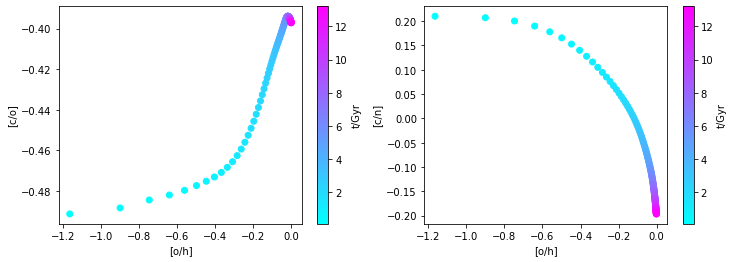

In [121]:
yields.set_yields()
compare_models("Fiducial", eta_factor=1)
sf("c_sz_fiducial")

/home/daniel/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


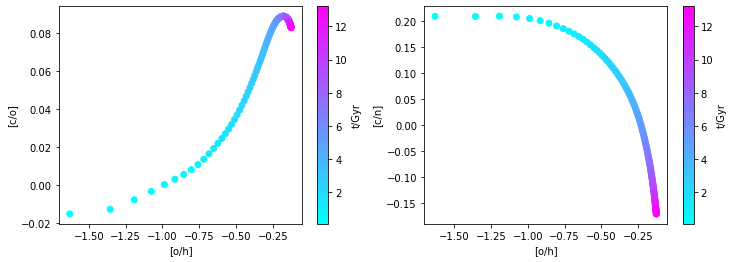

In [15]:
yields.set_yields()
compare_models(title="reduced eta", eta_factor=1/3)
sf("c_sz_reduced_eta")

/home/daniel/surp/VICE/vice/core/singlezone/singlezone.py:1850: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: fe
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb fe yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb o y

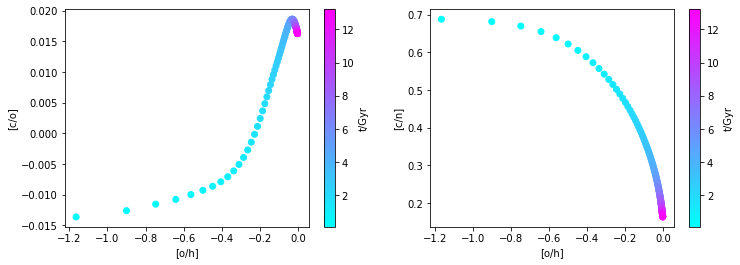

In [116]:
yields.set_yields()
vice.yields.ccsne.settings["c"]*=3
compare_models(title="increased ccsn c")
sf("c_sz_inc_cc")

/home/daniel/surp/VICE/vice/core/singlezone/singlezone.py:1850: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: fe
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb fe yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb o y

(-0.02, 0.08)

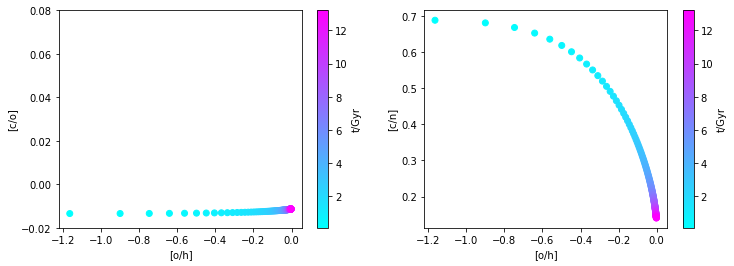

In [117]:
yields.set_yields()
vice.yields.ccsne.settings["c"]*=3
vice.yields.agb.settings["c"] = lambda m, z: 0.0
_, axs = compare_models(title="increased ccsn c, no agb")
axs[0].set_ylim(-0.02, 0.08)

/home/daniel/surp/VICE/vice/core/singlezone/singlezone.py:1850: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: fe
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb fe yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb o y

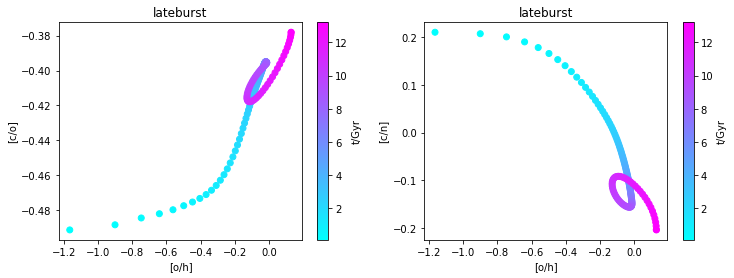

In [33]:
yields.set_yields()
compare_models(func = lateburst, title="lateburst")
sf("c_sz_lateburst")

/home/daniel/surp/VICE/vice/core/singlezone/singlezone.py:1850: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: fe
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb fe yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb o y

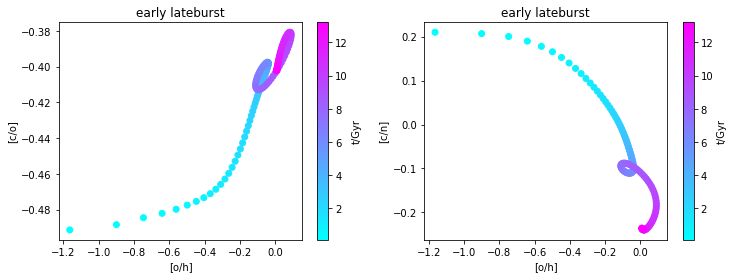

In [34]:
yields.set_yields()
A = 1
t_burst = 8
compare_models(func = lateburst, title="early lateburst")
sf("c_sz_earlyburst")

/home/daniel/surp/VICE/vice/core/singlezone/singlezone.py:1850: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: fe
  warnings.warn("""\
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb fe yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb o y

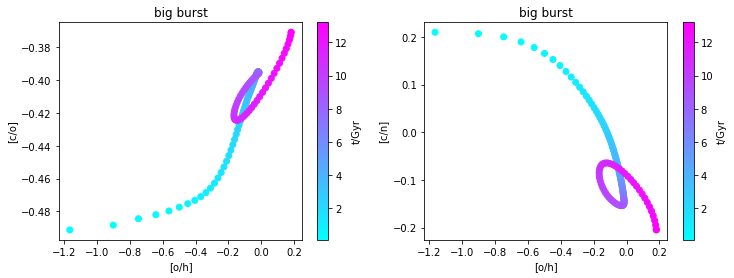

In [36]:
yields.set_yields()
A = 2.5
t_burst = 11.2
compare_models(func = lateburst, title="big burst")
sf("c_sz_bigburst")

(<Figure size 864x288 with 4 Axes>,
 array([<AxesSubplot:xlabel='[o/h]', ylabel='[c/o]'>,
        <AxesSubplot:xlabel='[o/h]', ylabel='[c/n]'>], dtype=object))

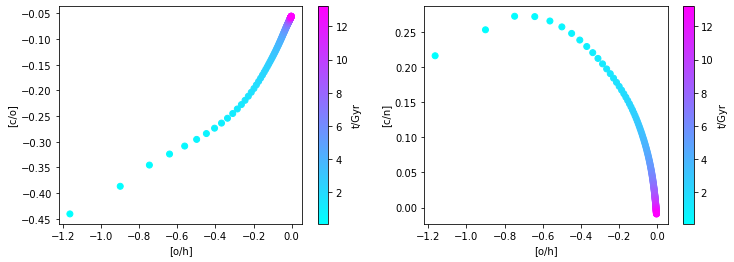

In [18]:
yields.set_yields()



M_Hs = [-3, -2, -1, 0]
y_c = [vice.yields.ccsne.fractional("c", MoverH=M_H, rotation=300, study="LC18")[0] for M_H in M_Hs]
y_n = [vice.yields.ccsne.fractional("n", MoverH=M_H, rotation=300, study="LC18")[0] for M_H in M_Hs]
Z = [0.014*10**M_H for M_H in M_Hs]
f = vice.toolkit.interpolation.interp_scheme_1d(Z, y_c)
f_n = vice.toolkit.interpolation.interp_scheme_1d(Z, y_n)
vice.yields.ccsne.settings["C"] = f
vice.yields.ccsne.settings["N"] = f_n


compare_models(title="yee burst")

In [16]:
vice.yields.ccsne.settings?

In [ ]:
Z = 0.014*10**(np.linspace(-2, 0.4, 100))
y = [vice.yields.ccsne.settings["C"][]]